# Bibliotecas

Vamos usar a biblioteca de alto nível [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/) que contém a implementação do Deep Q-learning (DQN), dentre outros algoritmos de aprendizado por reforço.

In [54]:
# Importa as bibliotecas principais
import gymnasium as gymm       
# Biblioteca de simulações de ambientes para RL
import imageio                        # Usada para salvar a sequência de frames como GIF
from IPython.display import Image     # Para exibir a imagem (GIF) diretamente no notebook
import numpy as np                    # Importa o pacote NumPy, amplamente utilizado para manipulação de arrays e operações numéricas vetoriais
from typing import Dict, Tuple, List  # Importa ferramentas de tipagem estática do Python
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, ProgressBarCallback
from stable_baselines3.common.monitor import Monitor
from torchinfo import summary
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import torch
import pandas as pd
import seaborn as sns

# Ambientes

In [55]:
ambientes = ["MountainCar-v0", "CartPole-v1", "Acrobot-v1"]
amb = ambientes[1]
train_env = Monitor(gymm.make(amb, render_mode=None))
eval_env  = Monitor(gymm.make(amb, render_mode=None))

# Callback

In [56]:
# Configura avaliação periódica
eval_cb = EvalCallback(
    eval_env,                 	  # ambiente só para avaliação
    eval_freq=1000,               # faz avaliação a cada 1 000 passos de treino
    n_eval_episodes=1,           # roda 10 episódios por avaliação
    log_path="./logs/" + amb,     # grava evaluations.npz nessa pasta
    deterministic=True,           # usa ações gulosas
    verbose=0                     # sem mensagens no console
)

# Hiperparâmetros

In [57]:
params = {
    "CartPole-v1": {
        "policy": "MlpPolicy",
        "learning_rate": 2.3e-3,
        "batch_size": 64,
        "buffer_size": 100_000,
        "learning_starts": 1_000,
        "gamma": 0.99,
        "target_update_interval": 10,
        "train_freq": 256,
        "gradient_steps": 128,
        "exploration_fraction": 0.16,
        "exploration_final_eps": 0.04,
        "policy_kwargs": {"net_arch": [256, 256]},
    },
    "MountainCar-v0": {
        "policy": "MlpPolicy",
        "learning_rate": 4e-3,
        "batch_size": 128,
        "buffer_size": 10_000,
        "learning_starts": 1_000,
        "gamma": 0.98,
        "target_update_interval": 600,
        "train_freq": 16,
        "gradient_steps": 8,
        "exploration_fraction": 0.20,
        "exploration_final_eps": 0.07,
        "policy_kwargs": {"net_arch": [256, 256]},
    },
    "Acrobot-v1": {
        "policy": "MlpPolicy",
        "learning_rate": 6.3e-4,
        "batch_size": 128,
        "buffer_size": 50_000,
        "learning_starts": 0,
        "gamma": 0.99,
        "target_update_interval": 250,
        "train_freq": 4,
        "gradient_steps": -1,
        "exploration_fraction": 0.12,
        "exploration_final_eps": 0.10,
        "policy_kwargs": {"net_arch": [256, 256]},
    },
}
n_timesteps = {
    "CartPole-v1": 5e4,
    "MountainCar-v0": 1.2e5,
    "Acrobot-v1":1e5
}

[**Hiperparâmetros**](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html#):

`learning_rate`: taxa de aprendizado

`batch_size`: tamanho do mini lote.

`buffer_size`: capacidade máxima do replay buffer; ao atingir o limite, amostras mais antigas são sobrescritas.

`learning_starts`: número de interações com o ambiente antes de iniciar o treinamento.

`gamma`: fator de desconto.

`train_freq`: frequência (em passos de ambiente) com que a rede é atualizada; a cada train_freq interações executa-se um ciclo de treino.

`gradient_steps`: número de passos de otimização consecutivos executados.

`target_update_interval`: número de passos entre as atualizações dos pesos da rede-alvo.

`exploration_fraction`: fração do total de passos de treino para decaimento de epsilon.

`exploration_final_eps`: valor final de epsilon após o decaimento.

`policy_kwargs = dict(net_arch=[256, 256])`: argumentos adicionais passados à política; aqui define-se uma MLP com duas camadas totalmente conectadas de 256 unidades cada.

# Modelo

In [58]:
params[amb].update({"env": train_env, "verbose": 0})
model = DQN(**params[amb])

In [59]:
summary(
    model.policy.q_net,
    input_size=(1,) + train_env.observation_space.shape,  # (batch_size, *observation_space.shape)
    col_names=["input_size", "output_size", "num_params"],
    depth=3
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
QNetwork                                 [1, 4]                    [1, 2]                    --
├─FlattenExtractor: 1-1                  [1, 4]                    [1, 4]                    --
│    └─Flatten: 2-1                      [1, 4]                    [1, 4]                    --
├─Sequential: 1-2                        [1, 4]                    [1, 2]                    --
│    └─Linear: 2-2                       [1, 4]                    [1, 256]                  1,280
│    └─ReLU: 2-3                         [1, 256]                  [1, 256]                  --
│    └─Linear: 2-4                       [1, 256]                  [1, 256]                  65,792
│    └─ReLU: 2-5                         [1, 256]                  [1, 256]                  --
│    └─Linear: 2-6                       [1, 256]                  [1, 2]                    514
Total params: 67,586
Traina

# Treinamento

In [60]:
model.learn(total_timesteps=n_timesteps[amb],
            callback=eval_cb,
            log_interval=None,
            progress_bar=True)
model.save("dqn")
model = DQN.load("dqn")

Output()

# Resultados

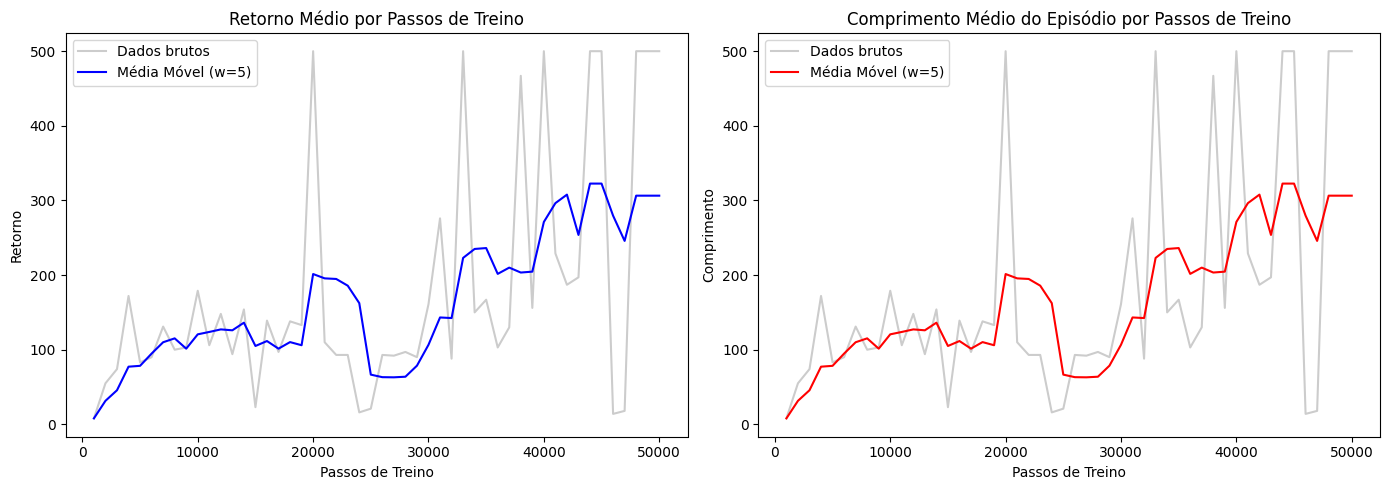

In [61]:
# 1. Carregar dados
data = np.load(f"logs/{amb}/evaluations.npz") # caminho passado para o EvalCallback
timesteps   = data["timesteps"]     # shape (n_evals,)
returns_raw = data["results"]      # shape (n_evals, n_eval_episodes)
lengths_raw = data["ep_lengths"]   # shape (n_evals, n_eval_episodes)

# 2. Calcular médias por ponto de avaliação
mean_ret = returns_raw.mean(axis=1)
mean_len = lengths_raw.mean(axis=1)

# 3. Criar DataFrame e média móvel (janela=5)
df = pd.DataFrame({
    "Passos de Treino": timesteps,
    "Retorno Médio": mean_ret,
    "Comprimento Médio": mean_len
})
df["Retorno MM"]     = df["Retorno Médio"].rolling(window=5, min_periods=1).mean()
df["Comprimento MM"] = df["Comprimento Médio"].rolling(window=5, min_periods=1).mean()

# 4. Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Retorno médio
sns.lineplot(
    x="Passos de Treino", y="Retorno Médio",
    data=df, ax=axes[0],
    label="Dados brutos",
    color="gray", alpha=0.4
)
sns.lineplot(
    x="Passos de Treino", y="Retorno MM",
    data=df, ax=axes[0],
    label="Média Móvel (w=5)",
    color="blue"
)
axes[0].set(
    title="Retorno Médio por Passos de Treino",
    xlabel="Passos de Treino",
    ylabel="Retorno"
)
axes[0].legend()

# Comprimento médio do episódio
sns.lineplot(
    x="Passos de Treino", y="Comprimento Médio",
    data=df, ax=axes[1],
    label="Dados brutos",
    color="gray", alpha=0.4
)
sns.lineplot(
    x="Passos de Treino", y="Comprimento MM",
    data=df, ax=axes[1],
    label="Média Móvel (w=5)",
    color="red"
)
axes[1].set(
    title="Comprimento Médio do Episódio por Passos de Treino",
    xlabel="Passos de Treino",
    ylabel="Comprimento"
)
axes[1].legend()

plt.tight_layout()
plt.show()

In [68]:
# Carrega o modelo e recria o ambiente
#["MountainCar-v0", "CartPole-v1", "Acrobot-v1"]

if amb == "MountainCar-v0":
  env    = gymm.make(amb)

  model = DQN.load("dqn", env=env, print_system_info=False)

  device = torch.device("cpu")
  # helper: SB3 policy → torch tensor → numpy Q-values
  def q_values(obs: np.ndarray) -> np.ndarray:
      with torch.no_grad():
          obs_t = torch.as_tensor(obs, dtype=torch.float32 , device=model.device)
          q = model.policy.q_net(obs_t).cpu().numpy()
      return q

  # Constrói a grade de estados (posição, velocidade)
  pos_min, pos_max = env.observation_space.low[0],  env.observation_space.high[0]
  vel_min, vel_max = env.observation_space.low[1],  env.observation_space.high[1]

  N = 100                              # resolução da malha
  pos = np.linspace(pos_min, pos_max, N)
  vel = np.linspace(vel_min, vel_max, N)
  P, V = np.meshgrid(pos, vel)        # cada um (N,N)

  grid_states = np.stack([P.ravel(), V.ravel()], axis=1)   # (N², 2)

  # Avalia a rede (cost-to-go)
  qs          = q_values(grid_states)            # (N², 3 ações)
  values      = np.max(qs, axis=1)               # V(s) = max_a Q(s,a)
  cost_to_go  = - values.reshape(N, N)           # sinal trocado

  # Gráfico interativo
  surf = go.Surface(x=P, y=V, z=cost_to_go, colorscale="Viridis", showscale=False)
  fig_plotly = go.Figure(surf)
  fig_plotly.update_layout(
      title="Superfície cost-to-go (DQN) | Ambiente: " + amb,
      scene=dict(xaxis_title="Position",
                yaxis_title="Velocity",
                zaxis_title="Cost-to-go (–max Q)",
                aspectratio=dict(x=1, y=1, z=0.5)),
      margin=dict(l=0, r=0, b=0, t=30)
  )
  fig_plotly.show()

# Simulacão com a rede treinada

In [69]:
env = gymm.make(amb, render_mode="rgb_array")
frames   = []
episodes = 1              # how many episodes to record
max_steps = 500           # MountainCar episode length
for ep in range(episodes):
    observation, info = env.reset()
    for step in range(max_steps):
        # agent acts
        action, _states = model.predict(observation, deterministic=True)
        observation, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            break
env.close()

In [70]:
# Salva os frames coletados como um arquivo GIF animado
gif_path = amb + ".gif"
imageio.mimsave(gif_path, frames, format="GIF", duration=40)

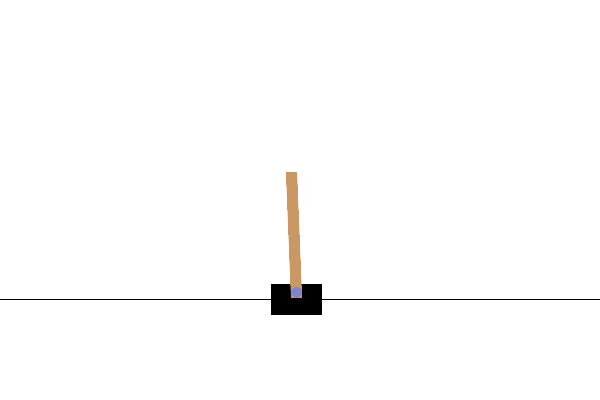

In [71]:
# Exibe o GIF diretamente no notebook
Image(filename=gif_path)

# Tarefa de Experimentos de Sensibilidade a Hiperparâmetros

Para cada um dos três ambientes, formule e execute 4 experimentos distintos em que apenas um hiperparâmetro é variado enquanto todos os outros são mantidos constatntes. Em seguida compare o desempenho (recompensa média e comprimento de episódio) entre as configurações testadas.

Cada um dos 4 experimentos deve:
- Manter todos os outros parâmetros fixos,
- Coletar métricas de recompensa média e comprimento/estabilidade do episódio
- Analisar gráficos comparativos e discorrer sobre como a alteração impactou o aprendizado.